load datasets from kaggle 

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

before first line you need to import kaggle.json into filesystem



In [ ]:
# google colab
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle competitions download cifar-10
#!unzip cifar-10.zip

In [1]:
#kaggle notebook
!pip install torchsummary
!pip install --upgrade torch torchvision

     |████████████████████████████████| 750.6 MB 8.6 kB/s                           | 252.6 MB 20.6 MB/s eta 0:00:25��████████▌                  | 316.4 MB 38.1 MB/s eta 0:00:12| 649.4 MB 8.6 MB/s eta 0:00:12 �████████▉    | 653.2 MB 8.6 MB/s eta 0:00:12 
     |████████████████████████████████| 21.0 MB 32.6 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.5.3 requires torch<1.11,>=1.7.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.9.1 requires torch<1.11.0,>=1.6.0, but you have torch 1.11.0 which is inco

In [3]:
!pip install py7zr

In [4]:
#!python -m py7zr x ./train.7z # colab 
!python -m py7zr x ../input/cifar-10/train.7z #kaggle notebook

In [72]:
#!python -m py7zr x ./test.7z
!python -m py7zr x ../input/cifar-10/test.7z #kaggle notebook

In [5]:
#imports
import math
import random
import copy
import os

import pandas as pd
import numpy as np

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary
from torchvision import models

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm


In [6]:
#variable
IMG_SIZE = 32

In [80]:
hyp = {
    #regularization hyperparameters
    "dropout_rate" : 0.3,
    "data_augmentation_rate" : 0.09, # probabilty of any transformation = 1 - (1 - data_augmentation_rate)**(Number of transformation)
    "data_augmentation_rate_mix" : 0.05,



    #leraning hyperparameters
    "batch_size" : 64,
    "lerning_rate" :  1e-3,
    "shuffle" : True
}


In [8]:
class CustomImageDataset(Dataset):
    def __init__(self,  img_dir,annotations_file = None,transform = None):
      self.img_labels = None
      self.le = preprocessing.LabelEncoder()
      if  annotations_file is not None:
        self.img_labels = pd.read_csv(annotations_file)
        self.img_labels['index_label'] = self.le.fit_transform(self.img_labels.iloc[:,1])
      self.img_dir = img_dir
      self.transform = transform

    def __len__(self):
      if self.img_labels is None:
        return len(os.listdir(self.img_dir))
      return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(idx + 1) + '.png')
        image = read_image(img_path)
        label = F.one_hot(torch.tensor(1),10).float()
        if  self.img_labels is not None:
          label = self.img_labels.iloc[idx, 2]
          label = torch.tensor(int(label))
          label = F.one_hot(label,10).float()

        # apply transformations
        if self.transform:
          for t in self.transform:
            image = t(image)
        return image, label
          
    def getLabel(self,idx):
      if  self.img_labels is not None:
        return self.img_labels.iloc[idx,1]
      return None

    def encodeLabel(self, idx):
      if self.img_labels is None:
        return None
      return self.le.inverse_transform(idx)

In [9]:
class RandomProbabilityWrapper:

    def __init__(self,probability,transformation):
        self.transformation = transformation
        self.probability = probability


    def __call__(self, img):
        if random.random() < self.probability:
            return self.transformation(img)
        return img

In [10]:
class Cutmix:
  def __init__(self,probability, dataset):
    self.probability = probability
    self.dataset = dataset
    
  def transform(self, batch):
    indexes = np.where(np.random.rand(len(batch[0])) < self.probability)[0]
    print(indexes)
    for i in indexes:
        rand_index = random.randint(0,len(self.dataset) - 1 )
        second_image, second_label = self.dataset[rand_index]
        batch[0][i], batch[1][i] = self(batch[0][i], batch[1][i],second_image, second_label)
    return batch
    


  def __call__(self, image1, label1, image2, label2, beta_coff = 0.3,debug = False):
    ratio = np.random.beta(beta_coff, beta_coff, size=None)
    a = int(math.sqrt(ratio) * IMG_SIZE)
    x = random.randint(0, IMG_SIZE -1)
    y = random.randint(0, IMG_SIZE -1)
    x2 = x + a if x + a < IMG_SIZE else IMG_SIZE
    y2 = y + a if y + a < IMG_SIZE else IMG_SIZE
    width = x2 - x
    height = y2 - y
    ratio = width * height * 1.0 / (IMG_SIZE ** 2)

    crop2 = T.functional.crop(image2, y, x, height, width) #take only selected part 
    image2 = T.functional.pad(crop2, [x, y, IMG_SIZE - x2, IMG_SIZE - y2]) #set it on image dimenzions black image

    crop1 = T.functional.crop(image1, y, x, height, width)
    img1 = T.functional.pad(crop1, [x, y, IMG_SIZE - x2, IMG_SIZE - y2])

    image1 = image1 - img1
    image = image1 + image2

    label = ratio * label2 + (1 - ratio) * label1
    if debug == True:
        print("a = " + str(a))
        print("x, y = " +str(x) + ", "+str(y))
        print("x2, y2 = " +str(x2) + ", "+str(y2))
        print("width, height = " +str(width) + ", "+str(height))
        
    return image, label

In [11]:
class DataAugmentationLayer(nn.Module):
    def __init__(self, image_transformation = []):
        super().__init__()
        self.image_transformation = image_transformation

    def forward(self, x):
        if self.training == True:
            for t in self.image_transformation:
                x = t(x)          
        return x    

In [12]:
class TransformationLayer(nn.Module):
    def __init__(self, image_transformation = []):
        super().__init__()
        self.image_transformation = image_transformation

    def forward(self, x):
        for t in self.image_transformation:
            x = t(x)          
        return x    

In [81]:
#cifar10_dataset = CustomImageDataset("./train/","./trainLabels.csv") # google colab
cifar10_dataset = CustomImageDataset("./train/","../input/cifar-10/trainLabels.csv") #kaggle notebook

In [82]:
train_datasets, val_datasets = train_test_split(cifar10_dataset, test_size=0.2)

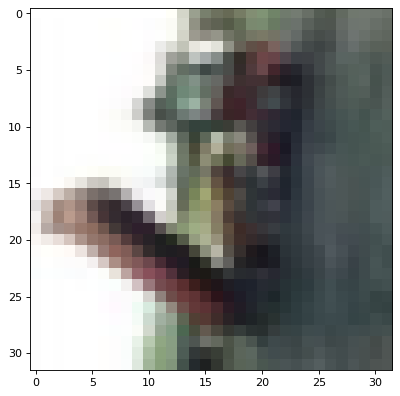

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
truck


In [83]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
imgNum = 2
arr_ = cifar10_dataset[imgNum][0]
plt.imshow(arr_.T)
plt.show()
print(cifar10_dataset[imgNum][1])
print(cifar10_dataset.getLabel(imgNum))


In [84]:
rotation = RandomProbabilityWrapper(hyp["data_augmentation_rate"], lambda x : T.functional.rotate(x,int(np.random.choice([90,180,270]))))
resize_cropper = RandomProbabilityWrapper(hyp["data_augmentation_rate"], lambda x :T.RandomResizedCrop(size=(32, 32))(x))
affine = RandomProbabilityWrapper(hyp["data_augmentation_rate"], lambda x :T.RandomAffine(degrees=0, translate=(0.1, 0.4), scale=(1,1))(x))

cutmix = Cutmix(hyp["data_augmentation_rate_mix"],cifar10_dataset)

    

In [85]:
dataAugumentation = DataAugmentationLayer(image_transformation = [rotation,resize_cropper,affine])

In [86]:
train_dataloader = DataLoader(train_datasets, batch_size=hyp["batch_size"], shuffle=hyp["shuffle"])
val_dataloader = DataLoader(val_datasets, batch_size=hyp["batch_size"], shuffle=hyp["shuffle"])

a = 24
x, y = 4, 4
x2, y2 = 28, 28
width, height = 24, 24


Text(0.5, 1.0, "['tensor([0.0000, 0.4375, 0.0000, 0.0000, 0.5625, 0.0000, 0.0000, 0.0000, 0.0000,\\n        0.0000])--> deer']")

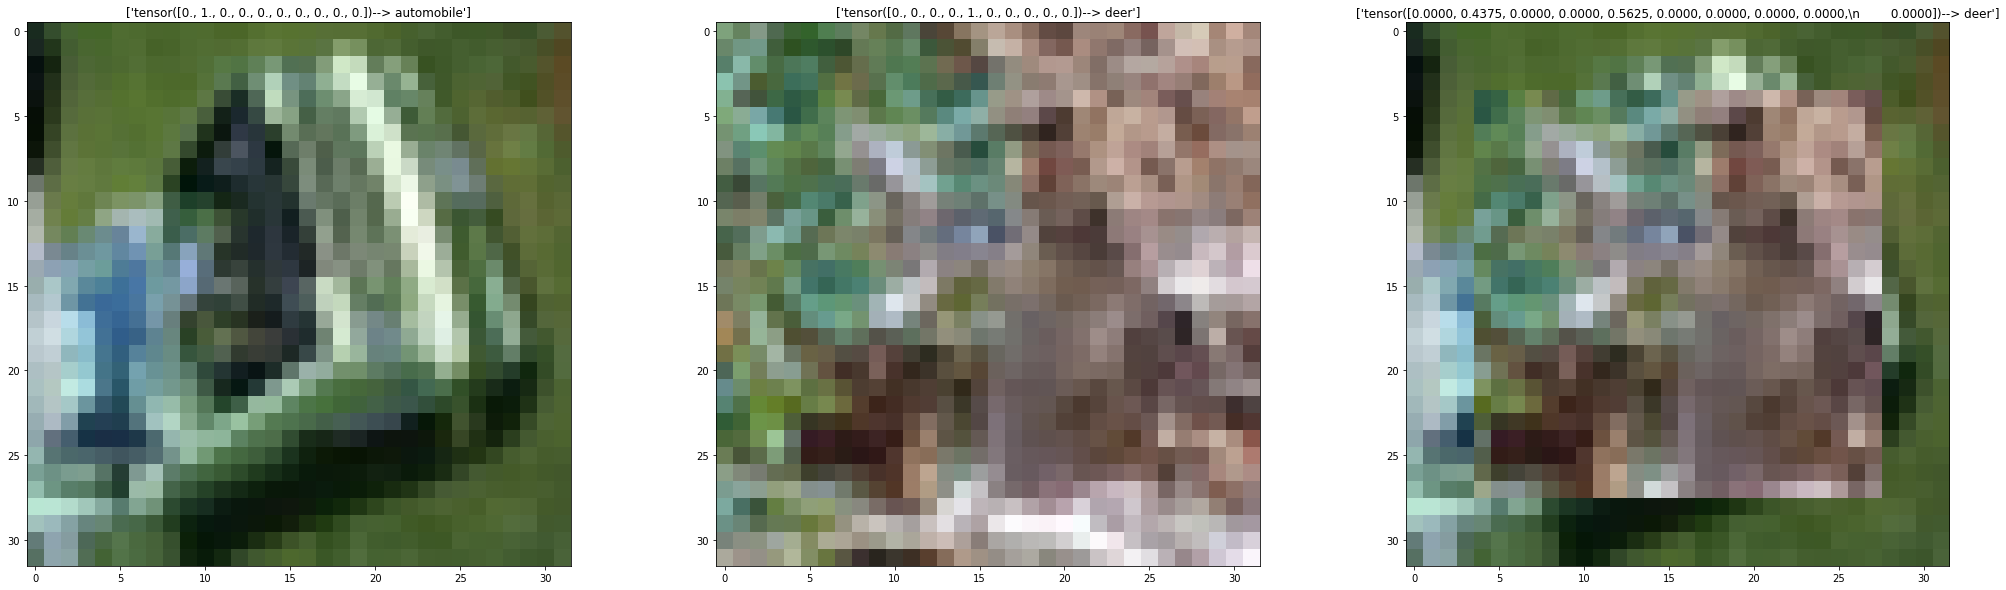

<Figure size 640x480 with 0 Axes>

In [87]:
imgNum = random.randint(0,len(cifar10_dataset))
imgNum1 =random.randint(0,len(cifar10_dataset))
figsize=(8, 6)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(35, 10) )
i1,l1 = cifar10_dataset[imgNum]
ax1.imshow(i1.int().T)
ax1.set_title(str(l1) + "--> " + cifar10_dataset.encodeLabel([torch.argmax(l1)]))

i2,l2 = cifar10_dataset[imgNum1]
ax2.imshow(i2.int().T)
ax2.set_title(str(l2) + "--> " + cifar10_dataset.encodeLabel([torch.argmax(l2)]))


cut_test = Cutmix(1,cifar10_dataset)

figure(figsize=(8, 6), dpi=80)
image, label = cut_test(i1,l1,i2,l2,debug = True)
ax3.imshow(image.int().T)
ax3.set_title(str(label) + "--> " + cifar10_dataset.encodeLabel([torch.argmax(label)]))



In [18]:
def train(model, train_dataloader, test_dataloader = None, num_epochs=1, lr=1e-3, keepBest = False, mix_trainsformation = None):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  array_loss_train = np.empty([0])
  array_loss_val = np.empty([0])
  #with wandb.init(project="UZOP_LAB"):
  #model.cuda(0)
  best_model_wts = None
  best_lost = None

  for epoch in range(num_epochs):
    correct_train = 0
    model.train()
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Training (epoch={epoch}/{num_epochs})') as epoch_progress:
      for batch_idx, train_batch in epoch_progress:
        if mix_trainsformation is not None:
            for t in mix_trainsformation:
                train_batch = t.transform(train_batch)
                
        x, y = train_batch      
        x = x.float().cuda()
        y = y.cuda()
        logits = model(x)
        value, predicted = torch.max(logits, 1)
        loss = F.cross_entropy(logits, y)
        epoch_correct = (predicted==torch.argmax(y, dim=1)).sum().item()
        correct_train += epoch_correct
        epoch_progress.set_postfix({'loss': 1 - epoch_correct / hyp["batch_size"]})  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = 1 - (correct_train / len(train_dataloader.dataset))
    array_loss_train = np.append(array_loss_train,train_loss)
    print("Train loss " + str(train_loss))

    if test_dataloader is not None: 
      with torch.no_grad():
        model.eval()
        correct_val = 0
        for test_batch in tqdm(test_dataloader, desc="Testing"):
          x, y = test_batch
          x = x.float().cuda()
          y = y.cuda()

          logits = model(x)
          value, predicted = torch.max(logits, 1)
          loss = F.cross_entropy(logits, y)
          epoch_correct = (predicted==torch.argmax(y, dim=1)).sum().item()
          correct_val += epoch_correct

        val_loss = 1 - (correct_val / len(test_dataloader.dataset))
        array_loss_val = np.append(array_loss_val,val_loss)
        print("Val loss " + str(val_loss))

      if best_lost is None or best_lost > val_loss:
            best_lost = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

  if test_dataloader is not None: 
    if keepBest:
        model.load_state_dict(best_model_wts)
      
    model.eval()
    
    with torch.no_grad():
      test_loss = []
      correct = 0
      count = 0


      for test_batch in tqdm(test_dataloader, desc="Testing"):
        x, y = test_batch
        x = x.float().cuda()
        y = y.cuda()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        test_loss.append(loss)
        correct += (logits.argmax(dim=-1) == torch.argmax(y, dim=1)).float().sum()
        count += len(y)

      test_loss = torch.mean(torch.tensor(test_loss))
      test_acc = correct / count

      # Log test metrics
      # wandb.log({"test/loss": test_loss, "test/acc": test_acc})

      print()
      print(f"--- TEST ---")
      print("loss: ", test_loss.item())
      print("accuracy: ", test_acc.item())
  
  model.train()
  return array_loss_train, array_loss_val

In [91]:
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)

# reset final fully connected layer
num_ftrs = list(mobilenet_v3_large.classifier.children())[0].in_features

mobilenet_v3_large.classifier = nn.Sequential(
                        nn.Linear(num_ftrs, 256),  
                        nn.ReLU(), 
                        nn.Dropout(hyp["dropout_rate"]),
                        nn.Linear(256, 10))

resize = TransformationLayer(image_transformation = [T.Resize((224,244))])

mobilenet_v3_large = nn.Sequential(
    dataAugumentation,
    resize,
    mobilenet_v3_large
)

mobilenet_v3_large = mobilenet_v3_large.cuda()

In [92]:
summary(mobilenet_v3_large, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
DataAugmentationLayer-1            [-1, 3, 32, 32]               0
TransformationLayer-2          [-1, 3, 224, 244]               0
            Conv2d-3         [-1, 16, 112, 122]             432
       BatchNorm2d-4         [-1, 16, 112, 122]              32
         Hardswish-5         [-1, 16, 112, 122]               0
            Conv2d-6         [-1, 16, 112, 122]             144
       BatchNorm2d-7         [-1, 16, 112, 122]              32
              ReLU-8         [-1, 16, 112, 122]               0
            Conv2d-9         [-1, 16, 112, 122]             256
      BatchNorm2d-10         [-1, 16, 112, 122]              32
 InvertedResidual-11         [-1, 16, 112, 122]               0
           Conv2d-12         [-1, 64, 112, 122]           1,024
      BatchNorm2d-13         [-1, 64, 112, 122]             128
             ReLU-14         [-1, 6

In [93]:
init_weights_mobilenet = copy.deepcopy(mobilenet_v3_large.state_dict())

In [97]:
tr_loss, val_los = train(mobilenet_v3_large, train_dataloader, val_dataloader,num_epochs=15, lr = hyp["lerning_rate"])

Training (epoch=0/15): 100%|██████████| 625/625 [01:33<00:00,  6.66it/s, loss=0.141] 


Train loss 0.219375


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.51it/s]


Val loss 0.15190000000000003


Training (epoch=1/15): 100%|██████████| 625/625 [01:33<00:00,  6.66it/s, loss=0.109] 


Train loss 0.1351


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.58it/s]


Val loss 0.10409999999999997


Training (epoch=2/15): 100%|██████████| 625/625 [01:33<00:00,  6.67it/s, loss=0.234] 


Train loss 0.11295


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.52it/s]


Val loss 0.08220000000000005


Training (epoch=3/15): 100%|██████████| 625/625 [01:33<00:00,  6.68it/s, loss=0.0312]


Train loss 0.10665000000000002


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.59it/s]


Val loss 0.0807


Training (epoch=4/15): 100%|██████████| 625/625 [01:33<00:00,  6.67it/s, loss=0.0625]


Train loss 0.09675


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.44it/s]


Val loss 0.08440000000000003


Training (epoch=5/15): 100%|██████████| 625/625 [01:33<00:00,  6.67it/s, loss=0.0938]


Train loss 0.08147499999999996


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.59it/s]


Val loss 0.07569999999999999


Training (epoch=6/15): 100%|██████████| 625/625 [01:33<00:00,  6.66it/s, loss=0.0312]


Train loss 0.07942499999999997


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.52it/s]


Val loss 0.08589999999999998


Training (epoch=7/15): 100%|██████████| 625/625 [01:33<00:00,  6.65it/s, loss=0.0312]


Train loss 0.07530000000000003


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.69it/s]


Val loss 0.08679999999999999


Training (epoch=8/15): 100%|██████████| 625/625 [01:33<00:00,  6.69it/s, loss=0.0625]


Train loss 0.06277500000000003


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.59it/s]


Val loss 0.06730000000000003


Training (epoch=9/15): 100%|██████████| 625/625 [01:33<00:00,  6.71it/s, loss=0.188] 


Train loss 0.06394999999999995


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.77it/s]


Val loss 0.0756


Training (epoch=10/15): 100%|██████████| 625/625 [01:33<00:00,  6.71it/s, loss=0.0781]


Train loss 0.06705000000000005


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.76it/s]


Val loss 0.07130000000000003


Training (epoch=11/15): 100%|██████████| 625/625 [01:33<00:00,  6.69it/s, loss=0]     


Train loss 0.05962500000000004


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.73it/s]


Val loss 0.06810000000000005


Training (epoch=12/15): 100%|██████████| 625/625 [01:33<00:00,  6.71it/s, loss=0.0469]


Train loss 0.062975


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.69it/s]


Val loss 0.07299999999999995


Training (epoch=13/15): 100%|██████████| 625/625 [01:33<00:00,  6.69it/s, loss=0.0625]


Train loss 0.05852500000000005


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.69it/s]


Val loss 0.06569999999999998


Training (epoch=14/15): 100%|██████████| 625/625 [01:33<00:00,  6.72it/s, loss=0.0156]


Train loss 0.05612499999999998


Testing: 100%|██████████| 157/157 [00:05<00:00, 29.66it/s]


Val loss 0.07210000000000005


Testing: 100%|██████████| 157/157 [00:05<00:00, 31.03it/s]


--- TEST ---
loss:  0.26329612731933594
accuracy:  0.927899956703186


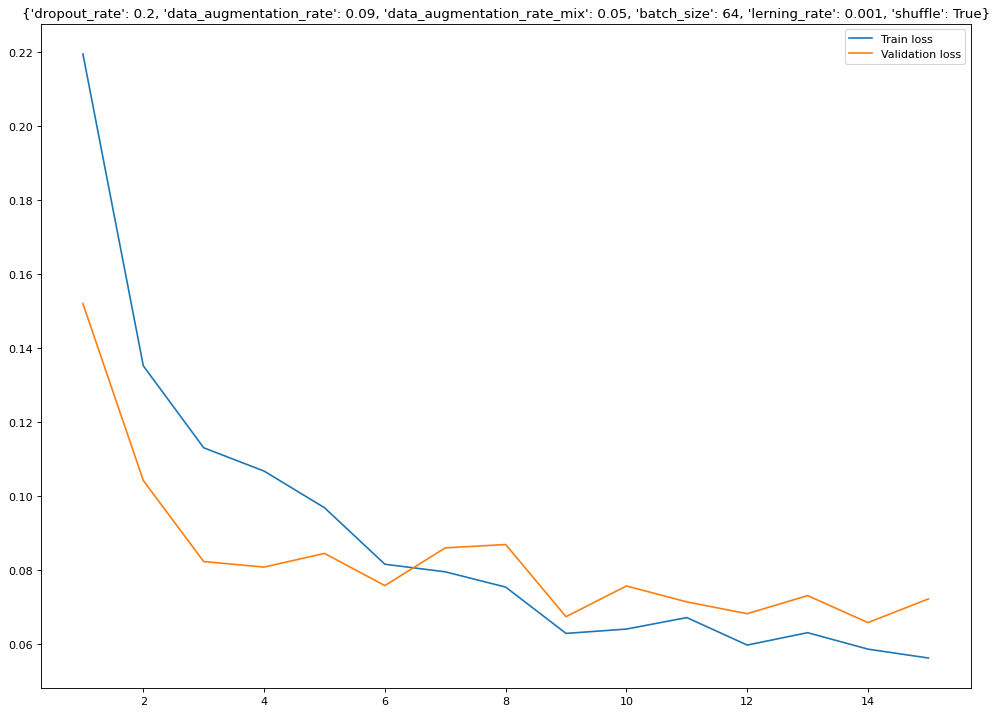

In [98]:
figure(figsize=(15,11), dpi=80)
plt.plot(range(1,16), tr_loss,label = "Train loss")
plt.plot(range(1,16), val_los, label = "Validation loss")
plt.title(hyp)
plt.legend()

In [101]:
epochs_num = np.argmin(val_los)
print("Epoch hyperparameter " + str(epochs_num))

Epoch hyperparameter 13


In [102]:
print("Best val loss")
val_los[epochs_num]

Best val loss


0.06569999999999998

In [104]:
def prediction(model,test_dataloader):
  with torch.no_grad():
    model.eval()
    prediction = np.empty([0], dtype=np.int8)


    for test_batch in tqdm(test_dataloader, desc="Testing"):
      x, _ = test_batch
      x = x.float().cuda()
      logits = model(x)
      tmp_arr = logits.argmax(dim=-1)
      prediction = np.append(prediction,tmp_arr.cpu().numpy())
  return prediction

In [106]:
cifar10_dataloader_noShuffle = DataLoader(val_datasets, batch_size=hyp["batch_size"], shuffle=False)

In [107]:
p = prediction(mobilenet_v3_large, cifar10_dataloader_noShuffle)

Testing: 100%|██████████| 157/157 [00:05<00:00, 29.80it/s]


In [108]:
p_encoded = cifar10_dataset.encodeLabel(p)
p2 = np.array([int(np.argmax(i[1])) for i in val_datasets])
p2_encoded = cifar10_dataset.encodeLabel(p2)
cm = confusion_matrix(p_encoded, p2_encoded)
cm

array([[976,   4,  16,   2,   7,   3,   4,   5,  42,   9],
       [  1, 976,   0,   0,   0,   2,   0,   0,   2,  72],
       [  7,   1, 977,  14,   7,  15,   9,   1,   2,   0],
       [  9,   2,  26, 931,  17, 141,  14,  14,   2,   1],
       [  3,   0,  19,   7, 933,  17,   5,  16,   1,   0],
       [  1,   0,   3,  22,  10, 844,   6,  16,   1,   0],
       [  4,   0,  13,   8,   8,   3, 892,   0,   2,   4],
       [  1,   0,   6,   8,  11,  11,   1, 908,   2,   0],
       [ 14,  15,   1,   1,   0,   0,   3,   1, 935,  10],
       [  6,   5,   0,   0,   0,   0,   0,   1,   4, 907]])

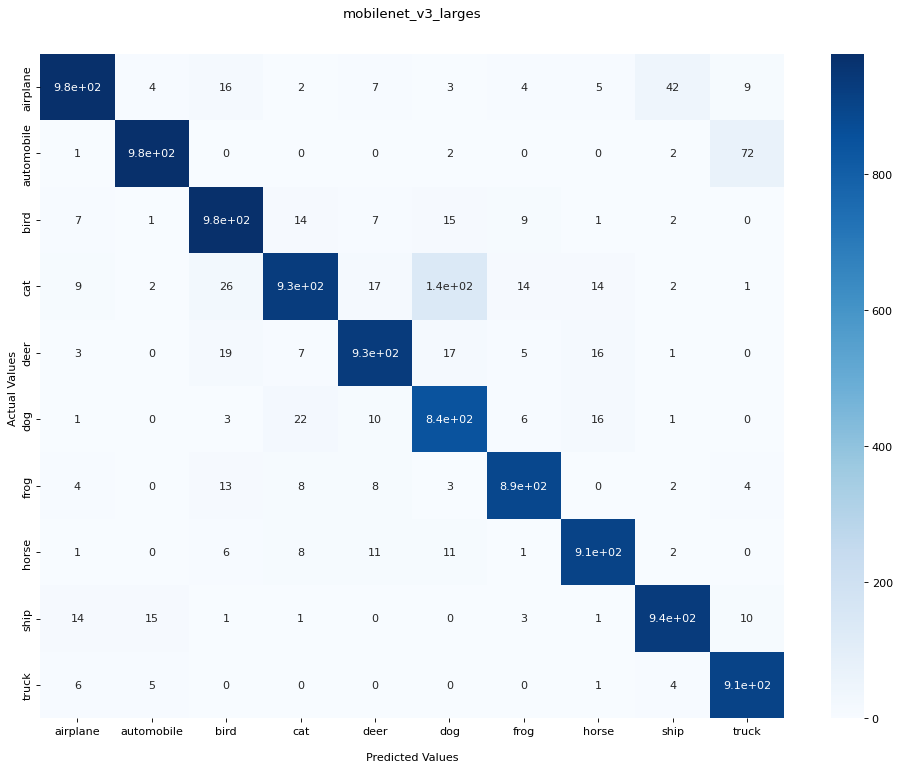

In [110]:
import seaborn as sns

figure(figsize=(15,11), dpi=80)

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('mobilenet_v3_larges\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(cifar10_dataset.encodeLabel(list(range(10))))
ax.yaxis.set_ticklabels(cifar10_dataset.encodeLabel(list(range(10))))

## Display the visualization of the Confusion Matrix.
plt.show()

In [111]:
from itertools import chain
from sklearn.utils import _safe_indexing

indexes = np.arange(len(cifar10_dataset))
cifar10_Whole = list(
        chain.from_iterable(
            (_safe_indexing(a, indexes)) for a in [cifar10_dataset]
        )
      )

In [113]:
cifar10_dataloader_Whole = DataLoader(cifar10_Whole, batch_size=hyp["batch_size"], shuffle=hyp["shuffle"])

In [114]:
mobilenet_v3_large.load_state_dict(init_weights_mobilenet)

<All keys matched successfully>

In [115]:
tr_loss, _ = train(mobilenet_v3_large, cifar10_dataloader_Whole,num_epochs=epochs_num,lr = hyp["lerning_rate"])

Training (epoch=0/13): 100%|██████████| 782/782 [01:56<00:00,  6.73it/s, loss=0.766] 


Train loss 0.19842000000000004


Training (epoch=1/13): 100%|██████████| 782/782 [01:56<00:00,  6.73it/s, loss=0.766] 


Train loss 0.12656


Training (epoch=2/13): 100%|██████████| 782/782 [01:56<00:00,  6.74it/s, loss=0.75]  


Train loss 0.10840000000000005


Training (epoch=3/13): 100%|██████████| 782/782 [01:56<00:00,  6.72it/s, loss=0.766] 


Train loss 0.10104000000000002


Training (epoch=4/13): 100%|██████████| 782/782 [01:56<00:00,  6.73it/s, loss=0.75]  


Train loss 0.09019999999999995


Training (epoch=5/13): 100%|██████████| 782/782 [01:56<00:00,  6.74it/s, loss=0.812] 


Train loss 0.07767999999999997


Training (epoch=6/13): 100%|██████████| 782/782 [01:56<00:00,  6.74it/s, loss=0.781] 


Train loss 0.07343999999999995


Training (epoch=7/13): 100%|██████████| 782/782 [01:56<00:00,  6.73it/s, loss=0.766] 


Train loss 0.07294


Training (epoch=8/13): 100%|██████████| 782/782 [01:56<00:00,  6.71it/s, loss=0.766] 


Train loss 0.07255999999999996


Training (epoch=9/13): 100%|██████████| 782/782 [01:56<00:00,  6.73it/s, loss=0.781] 


Train loss 0.06511999999999996


Training (epoch=10/13): 100%|██████████| 782/782 [01:56<00:00,  6.71it/s, loss=0.75]  


Train loss 0.05788000000000004


Training (epoch=11/13): 100%|██████████| 782/782 [01:56<00:00,  6.70it/s, loss=0.828] 


Train loss 0.05476000000000003


Training (epoch=12/13): 100%|██████████| 782/782 [01:56<00:00,  6.70it/s, loss=0.766] 

Train loss 0.06491999999999998


In [116]:
cifar10_dataset_test = CustomImageDataset("./test/")

In [117]:
test_dataloader = DataLoader(cifar10_dataset_test, batch_size=hyp["batch_size"], shuffle=False)


In [118]:
 p_test = prediction(mobilenet_v3_large, test_dataloader)

Testing: 100%|██████████| 4688/4688 [04:10<00:00, 18.73it/s]


In [119]:
def preview(datasets,encoder, labels = None,index = None):
  if index is not None:
    figure(figsize=(8, 6), dpi=80)
    img, label = datasets[index]
    if labels is not None:
      label = labels[index]
    plt.imshow(img.int().T)
    plt.show()
    print(encoder([label]))
    print()
    return

  visited = []

  for i, data in enumerate(datasets): 
    img, label = data
    if labels is not None:
      label = labels[i]
    if label in visited:
      continue
    figure(figsize=(8, 6), dpi=80)
    plt.imshow(img.int().T)
    plt.show()
    print(encoder([label]))
    print()
    visited.append(label)
    if len(visited) >= 10:
      break
    
    

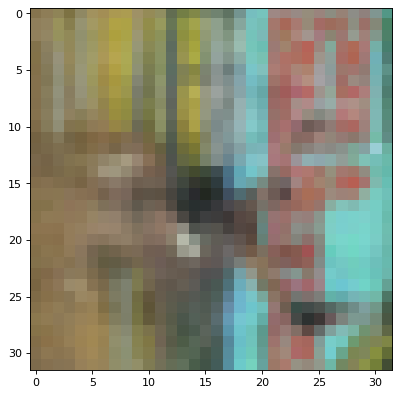

['deer']



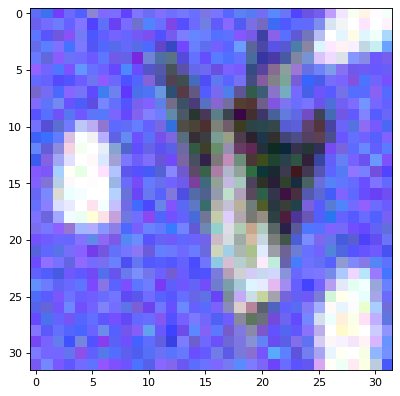

['airplane']



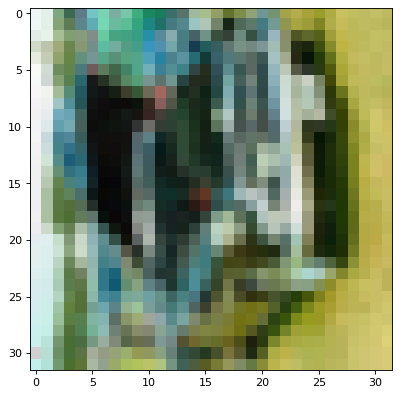

['automobile']



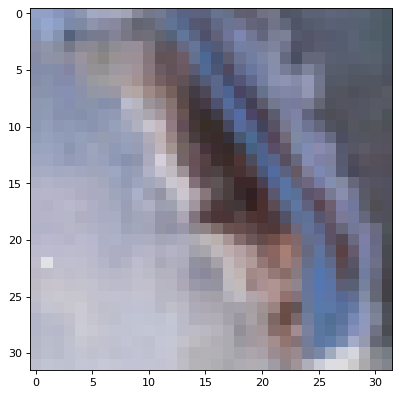

['ship']



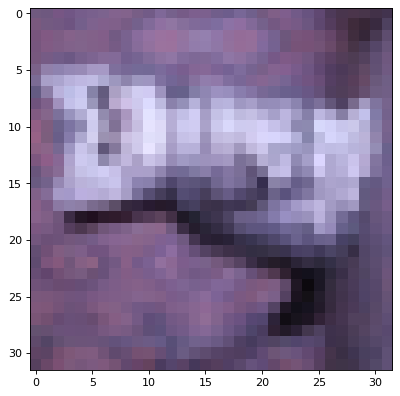

['cat']



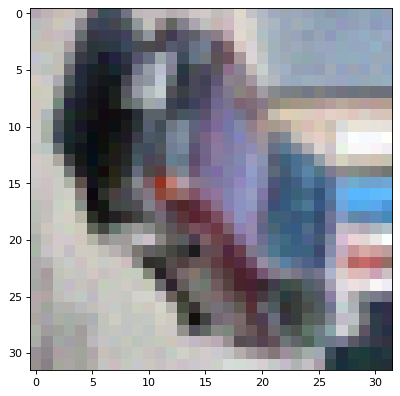

['truck']



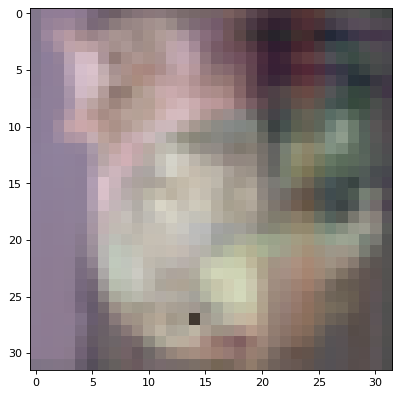

['bird']



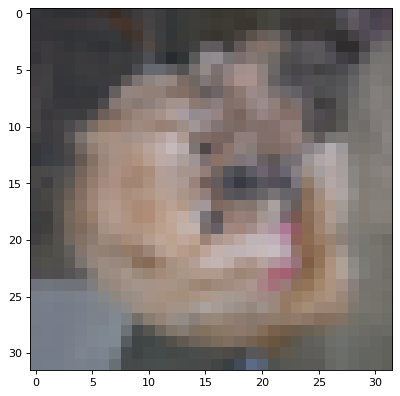

['dog']



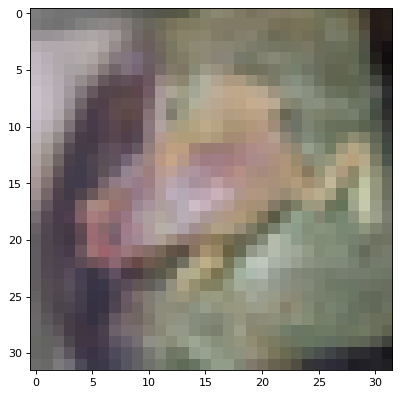

['frog']



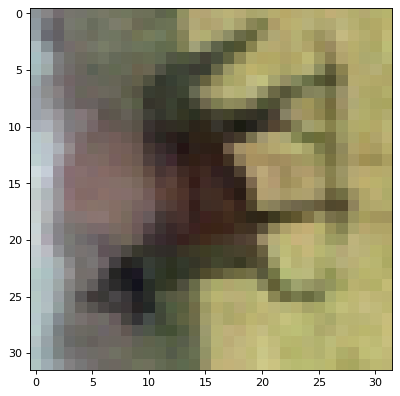

['horse']



In [120]:
preview(cifar10_dataset_test,lambda x: cifar10_dataset.encodeLabel(x),p_test)

In [121]:
df = pd.DataFrame(data=cifar10_dataset.encodeLabel(p_test))
df.columns = ["label"]
df.index += 1 

In [122]:
df.to_csv('submission.csv', index=True, index_label="id")

In [ ]:
#!kaggle competitions submit -c cifar-10 -f ../kaggle/working/submission.csv -m "Deep Learning, PW, First try"

